## **Creating Inset Maps**
This notebook will provide a tutorial on creating Inset Maps for maps created using matplotlib/pyplot.

Note that matplotlib *does* come with the ability to draw inset maps natively, via [`inset_axes()`](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.inset_axes.html) and [this other function](https://matplotlib.org/stable/api/_as_gen/mpl_toolkits.axes_grid1.inset_locator.inset_axes.html#mpl_toolkits.axes_grid1.inset_locator.inset_axes). However, I found these APIs to be confusing/poorly documented, and I hope the approach available in this package (which relies on these functions!) is more intuitive to the average end-user, and the expense of maybe some less flexiblity.

### **Set-Up**

In [1]:
# Packages used by this tutorial
import geopandas # manipulating geographic data
import shapely # manipulating geometries
import pygris # easily acquiring shapefiles from the US Census
import matplotlib.pyplot # visualization

In [ ]:
# Downloading the state-level dataset from pygris
states = pygris.states(cb=True, year=2022, cache=False).to_crs(3857)

In [3]:
# Importing the main package
from matplotlib_map_utils.core.inset_map import InsetMap, inset_map, ExtentIndicator, indicate_extent, DetailIndicator, indicate_detail

In [4]:
# This is just a function to create a new, blank map with matplotlib, with our default settings
def new_map(rows=1, cols=1, figsize=(5,5), dpi=150, ticks=False):
    # Creating the plot(s)
    fig, ax = matplotlib.pyplot.subplots(rows,cols, figsize=figsize, dpi=dpi)
    # Turning off the x and y axis ticks
    if ticks==False:
        if rows > 1 or cols > 1:
            for a in ax.flatten():
                a.set_xticks([])
                a.set_yticks([])
        else:
            ax.set_xticks([])
            ax.set_yticks([])
    # Returning the fig and ax
    return fig, ax

In [5]:
# This is using some utilities within the mmu package to help filter our states
from matplotlib_map_utils.utils import USA
usa = USA()
# Filtering based on FIPS codes
contiguous = states.query(f"GEOID in {usa.filter_contiguous(True)}")
alaska = states.query(f"GEOID == '{usa.filter_abbr("AK")}'").to_crs(3467)
hawaii = states.query(f"GEOID == '{usa.filter_abbr("HI")}'").to_crs(4135)
hawaii.geometry = [shapely.MultiPolygon([g for g in hawaii.iloc[0].geometry.geoms if g.area>1e-3])] # optional; just selecting the largest islands of Hawaii
puerto_rico = states.query(f"GEOID == '{usa.filter_abbr("PR")}'").to_crs(4437)
washington_dc = states.query(f"GEOID == '{usa.filter_abbr("DC")}'")

### **Using the** `inset_map()` **function**
The quickest and easiest way to add an inset map to a single plot is using the `inset_map()` function. This function returns a `matplotlib.axes.Axes` object that can then be manipulated as usual, including plotting additional data.

<Axes: label='inset_axes'>

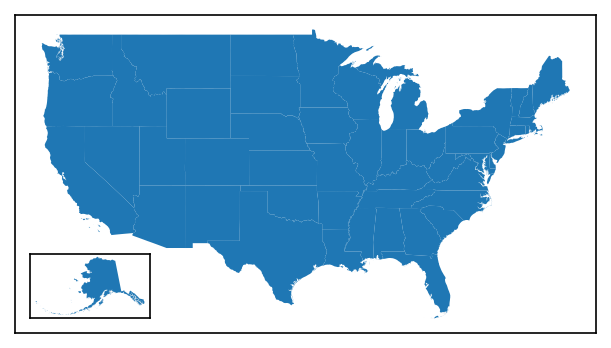

In [6]:
# Setting up the main plot
fig, ax = new_map()
# Plotting the contiguous USA
contiguous.plot(ax=ax)

# Adding an inset map to the plot
iax = inset_map(ax, location="lower left", size=0.8, pad=0.1, xticks=[], yticks=[])
# Plotting alaska in the inset map
alaska.plot(ax=iax)

### **Using the** ``InsetMap`` **class**
Alternatively, an `InsetMap` class is also provided that allows the same inset axis to be rendered like so:

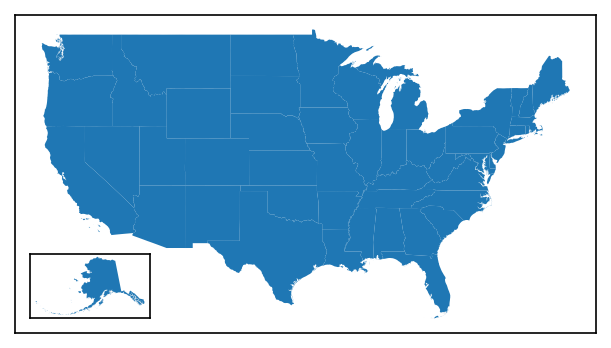

In [7]:
# Setting up the main plot
fig, ax = new_map()
# Plotting the contiguous USA
contiguous.plot(ax=ax)

# Creating an InsetMap object that we want to place in the lower-right corner of the axis, 
# Note that here, we do not specify the "parent" axis (ax)
# Note that we also tell it what data we are going to want to plot there, but this is optional!
im = InsetMap("lower left", size=0.8, pad=0.1, to_plot={"data":alaska}, xticks=[], yticks=[])
# The InsetMap can then be added using create()
# Note that this is DIFFERENT than NorthArrow and ScaleBar objects, which rely on add_artist()!
iax = im.create(ax)

#### **Re-using Objects**
The benefit of the InsetMap object is that it can be re-used across multiple plots without copy-pasting the function call. This is particularly beneficial for highly-customized insets: you can simply set it up once, and then add it to each axis you want.

Unlike with `ScaleBar` and `NorthArrow` objects, you do *not* need to use the `.copy()` call to create a deepcopy of an object before attaching it to an axis - the `.create()` function removes the need for this (and is useful enough that I am thinking of re-doing `ScaleBar` and `NorthArrow` to do the same thing).

#### **Updating Class Objects**
The customization options of the InsetMap can be accessed using dot notation (like im.base, im.label, etc.). They can also be updated from this dot notation by passing a valid value (see next section for details).

In [8]:
# Showing the size
im.size

0.8

In [9]:
# Updating the size
im.size = 0.75
im.size

0.75

In [10]:
# This also works for the kwargs stored in the InsetMap
im.kwargs

{'xticks': [], 'yticks': []}

### **Customizing the InsetMap**
Both the functional and object-oriented approach use the same inputs, so you can treat the following information as valid for both

#### **Primary Settings**
There are three primary settings that must be supplied each time an inset map is created:

* `location`: where the inset map will be placed relative to the (parent) plot. Will accept any of the options accepted by matplotlib for legend placement (`"upper right"`, `"center"`, `"lower left"`, etc., see *loc* in the [`matplotlib.pyplot.legend`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html) documentation). The default is `"lower left"`.

* `size`: what size you want the inset map to be, *in inches*; can be either a single number to create a square plot, or a tuple of 2 numbers to specify (width, height).

* `pad`: the space you want between the inset map and the edge of the parent plot, *in inches*; can be either a single number to have even padding on both the x- and y-axis, or a tuple of 2 numbers to specify (x, y) padding.

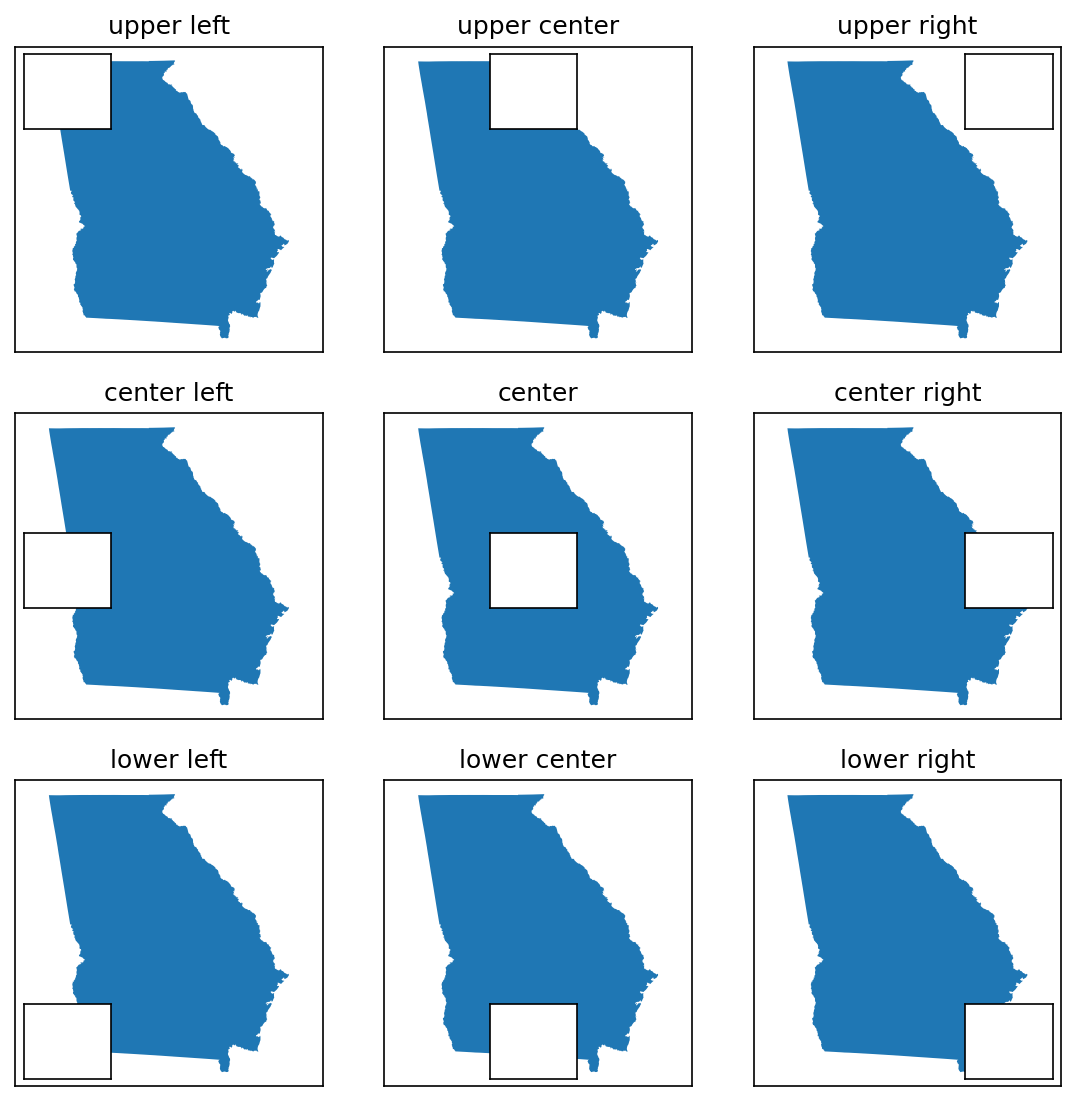

In [11]:
# Grid of location options
locs = ["upper left", "upper center", "upper right", "center left", "center", "center right", "lower left", "lower center", "lower right"]
# Creating a 9x9 grid of maps
fig, axs = new_map(3,3, figsize=(9,9))
for ax,l in zip(axs.flatten(), locs):
    states.query(f"NAME=='Georgia'").plot(ax=ax)
    ax.set_aspect(1, adjustable="datalim") # this is just making things square-ish for us
    ax.set_title(l)
    # Creating the inset map at our specified location
    inset_map(ax=ax, location=l, size=0.5, pad=0.05, xticks=[], yticks=[])

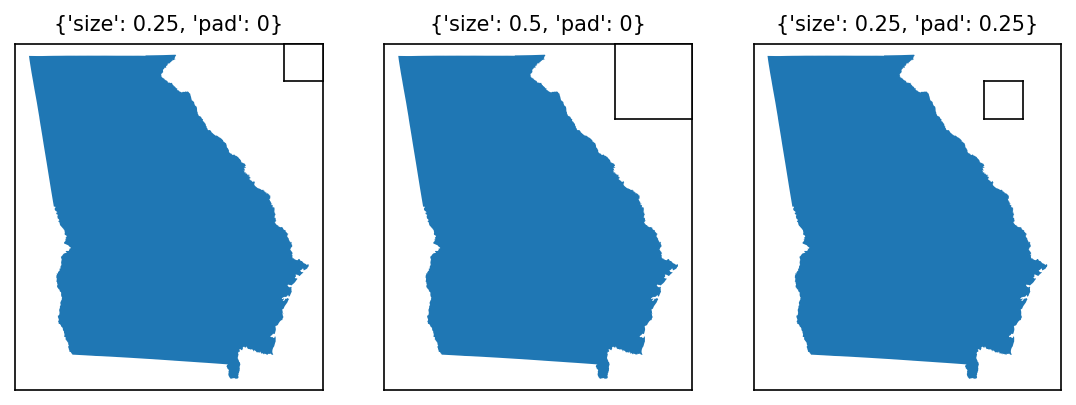

In [12]:
# Changing size and padding
modifications = [
    {"size":0.25,"pad":0},
    {"size":0.5,"pad":0},
    {"size":0.25, "pad":0.25},
]
fig, axs = new_map(1,3, figsize=(9,3))
for ax,l,m in zip(axs.flatten(), locs, modifications):
    states.query(f"NAME=='Georgia'").plot(ax=ax)
    ax.set_aspect(1, adjustable="datalim") # this is just making things square-ish for us
    ax.set_title(m, fontsize=10)
    inset_map(ax=ax, location="upper right", **m, xticks=[], yticks=[]) # **m unpacks our modifications, feel free to specify them as kwargs instead

#### **Advanced Options**
There are three sets of more advanced options that can be used to modify the inset map upon creation.

##### **Positioning**
Two optional arguments exist for specifying the position of the inset map with greater granularity than the `location` method specified above:

* `coords`: A two-tuple of coordinates specifying *where* the inset map should be placed. When provided, `location` is then used to determine which part of the inset map appears at those coordinates (ex. `upper left` would place the top-left corner of the inset map at those coordinates, `center` would place the center of the inset map there, etc.).

* `transform`: Allows you to specify what `matplotlib.transformation` the `coords` are in! By default, expects `ax.transAxes` coordinates, but another useful example would be `ax.transData` to place in geo-referenced coordinates instead. Note that this is not a validated argument, I expect you to know what you are doing if using this!

<Axes: label='inset_axes'>

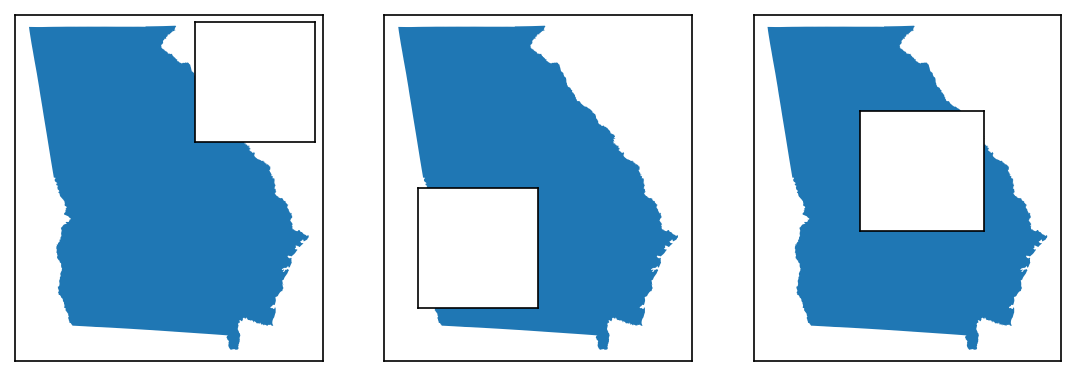

In [13]:
fig, axs = new_map(1,3, figsize=(9,3))
for ax,l,m in zip(axs.flatten(), locs, modifications):
    states.query(f"NAME=='Georgia'").plot(ax=ax)
    ax.set_aspect(1, adjustable="datalim") # this is just making things square-ish for us
    
# First, a default for comparison
inset_map(ax=axs[0], location="upper right", size=0.8, pad=0.05, xticks=[], yticks=[])
# Placing the upper right corner of the inset axes in the middle of the map
inset_map(ax=axs[1], location="upper right", size=0.8, pad=0.05, coords=(0.5,0.5), xticks=[], yticks=[])
# Placing the upper left corner of the inset axes on Atlanta, GA, using ax.transData
inset_map(ax=axs[2], location="upper left", size=0.8, pad=0.05, coords=(-9353446,4007500), transform=axs[2].transData, xticks=[], yticks=[])

##### **Plotting**
The `InsetMap` object accepts a unique keyword argument, that `inset_map()` cannot use: `to_plot`. `to_plot` allows you to pass a *list of dictionaries* containing (a) data you want plotted on the map upon creation, and (b) the keyword arguments you want to pass to plot that data.

This helps in particular when you are re-using inset maps across multiple distinct plots - instead of having to create the inset and then plot + style the data each time, you can specify the data you want plotted once, and then just call `.create()` each time you want to display it!

Each dictionary in the list must follow this form:

* `data`: The data to be plotted on the inset map. Right now, work with anything that will accept a `.plot()` function call, and is intended primarily for GeoPandas GeoDataFrames and similar. This key is *required*.

* `kwargs`: A dictionary of the keyword arguments (and their associated values) passed to the `.plot()` function call. This key is *optional*, and only needed if you want non-default plotting behavior (which, to be fair, you probably do).

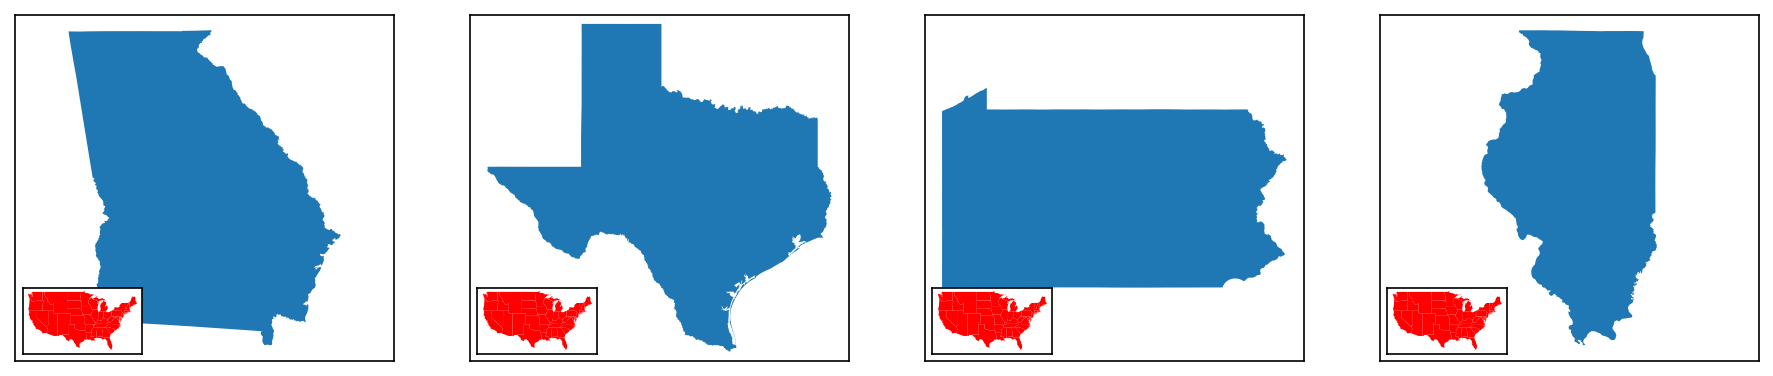

In [14]:
# This block will show how to re-use and plot data on an inset map
# One common use-case for this would be displaying a map of the US as you plot multiple individual US states

# Defining the inset map
im = InsetMap("lower left", size=0.8, pad=0.05, xticks=[], yticks=[], 
              to_plot=[{"data":contiguous, "kwargs":{"facecolor":"red"}}])

# Creating 1x3 subplots
fig, axs = new_map(1,4, figsize=(15,3))
# Now we define the different states
state_names = ["Georgia","Texas","Pennsylvania","Illinois"]
# Iterating through
for ax,s in zip(axs, state_names):
    states.query(f"NAME=='{s}'").plot(ax=ax)
    ax.set_aspect(1, adjustable="datalim")

# I'm specifying this as a separate function call/loop to ensure the sizes of the inset maps are consistent
# Otherwise, the constant re-calculation makes different sizes for each one
for ax in axs:
    im.create(ax)

##### **Kwargs**
Finally, both `InsetMap` and `inset_map` can accept any other keyword argument (kwarg) and pass it along to the `inset_axes` creation function used internally. The examples above have actually been showing this already: I use `xticks=[], yticks=[]` as kwargs to turn off the x and y ticks.

A full list of available kwargs can be found [here](https://matplotlib.org/stable/api/_as_gen/mpl_toolkits.axes_grid1.inset_locator.inset_axes.html#mpl_toolkits.axes_grid1.inset_locator.inset_axes).

<Axes: label='inset_axes'>

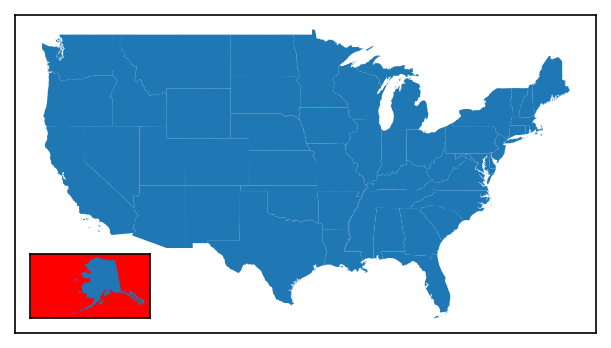

In [15]:
# Setting up the main plot
fig, ax = new_map()
# Plotting the contiguous USA
contiguous.plot(ax=ax)

# Adding an inset map to the plot with some kwargs for xticks, yticks, and facecolor
iax = inset_map(ax, location="lower left", size=0.8, pad=0.1, xticks=[], yticks=[], facecolor="red")
# Plotting alaska in the inset map
alaska.plot(ax=iax)

### **Tips and Tricks**

#### **Multiple Inset Maps**
Theoretically, there is no limit to the number of inset maps you can place - you'll just need a separate function call or object for each one!

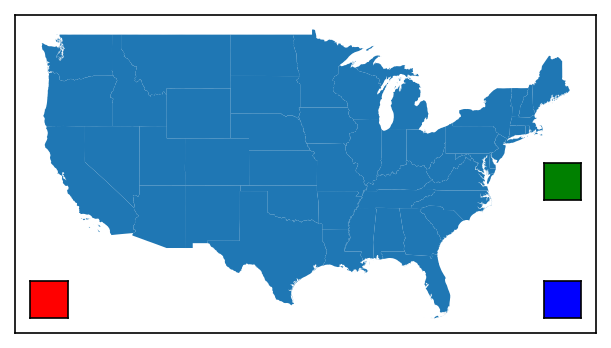

In [16]:
# Setting up the main plot
fig, ax = new_map()
# Plotting the contiguous USA
contiguous.plot(ax=ax)

# Adding multiple inset maps to the plot
iax = inset_map(ax, location="lower left", size=0.25, pad=0.1, xticks=[], yticks=[], facecolor="red") # using color so you can see which is which
iax = inset_map(ax, location="lower right", size=0.25, pad=0.1, xticks=[], yticks=[], facecolor="blue")
iax = inset_map(ax, location="center right", size=0.25, pad=0.1, xticks=[], yticks=[], facecolor="green")

#### **USA Inset Maps**
One of the most common inset maps I see is one where the contiguous United States is the "parent" axis, and then inset exist for Alaska, Hawaii, Puerto Rico, and/or Washington, DC. To facilitate the creation of these types a map, a specific function is available: `inset_usa()`.

<Axes: label='inset_axes'>

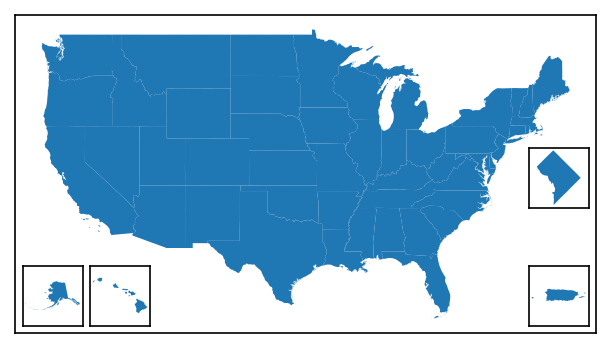

In [17]:
from matplotlib_map_utils.core.inset_map import inset_usa

# Setting up the main plot
fig, ax = new_map()
# Plotting the contiguous USA
contiguous.plot(ax=ax)

# Creating all the axes at once
# Note that each of the 4 states can be turned off individually!
aax, hax, pax, dax = inset_usa(ax, alaska=True, hawaii=True, dc=True, puerto_rico=True, size=0.4, pad=0.05, xticks=[], yticks=[], box_aspect=1)

alaska.plot(ax=aax)
hawaii.plot(ax=hax)
puerto_rico.plot(ax=pax)
washington_dc.plot(ax=dax)

#### **Inset Graphs**
While the function and object are technically called `InsetMap` and `inset_map`, the returned object is a matplotlib `Axes` object - meaning it can be used to insert *graphs* just as easily as another map, as shown below.

<BarContainer object of 5 artists>

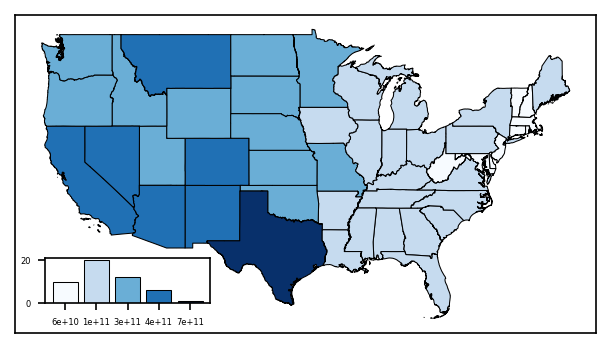

In [18]:
import mapclassify
import matplotlib
# Setting up the main plot
fig, ax = new_map()
# Plotting the contiguous USA, and shading by land area
contiguous.plot(ax=ax, column="ALAND", edgecolor="black", linewidth=0.5, 
                cmap="Blues", scheme="fisherjenks", classification_kwds={"k":5})

# Adding an axis to handle a graph below
# Don't worry too much about this code, it is quite messy and could be done better, but it should illustrate what is possible
jenks_land = mapclassify.FisherJenks(contiguous["ALAND"], k=5)
gax = inset_map(ax, location="lower left", size=(1.1,0.3), pad=0.2)
gax.tick_params(labelsize=4)
gax.bar(x=range(5), height=jenks_land.counts, color=matplotlib.colormaps["Blues"]([0,0.25,0.50,0.75,1]), 
        tick_label=["{:.0e}".format(b) for b in jenks_land.bins], edgecolor="black", linewidth=0.5)

#### **Setting Size**
While the inset map can nominally have its size changed by changing the relevant attribute, this can be tedious if you have to set it for every map.

Given that there are standardized paper sizes that most graphics are made towards, a specific function, `set_size()`, is provided that will batch-update the default values of the inset map to approximate what looks best at each size. The function takes in only one input, which is the size you want to update the inset to be:

* `xsmall` or `xs` for A8 paper, ~2 to 3 inches

* `small` or `sm` for A6 paper, ~4 to 6 inches

* `medium` or `md` for A4 or letter paper, ~8 to 11 inches

* `large` or `lg` for A2 paper, ~16 to 24 inches

* `xlarge` or `xl` for A0 paper, ~33 to 48 inches

These default values can be seen in `defaults/inset_map.py`; mostly, this function updates `size` and `pad`.

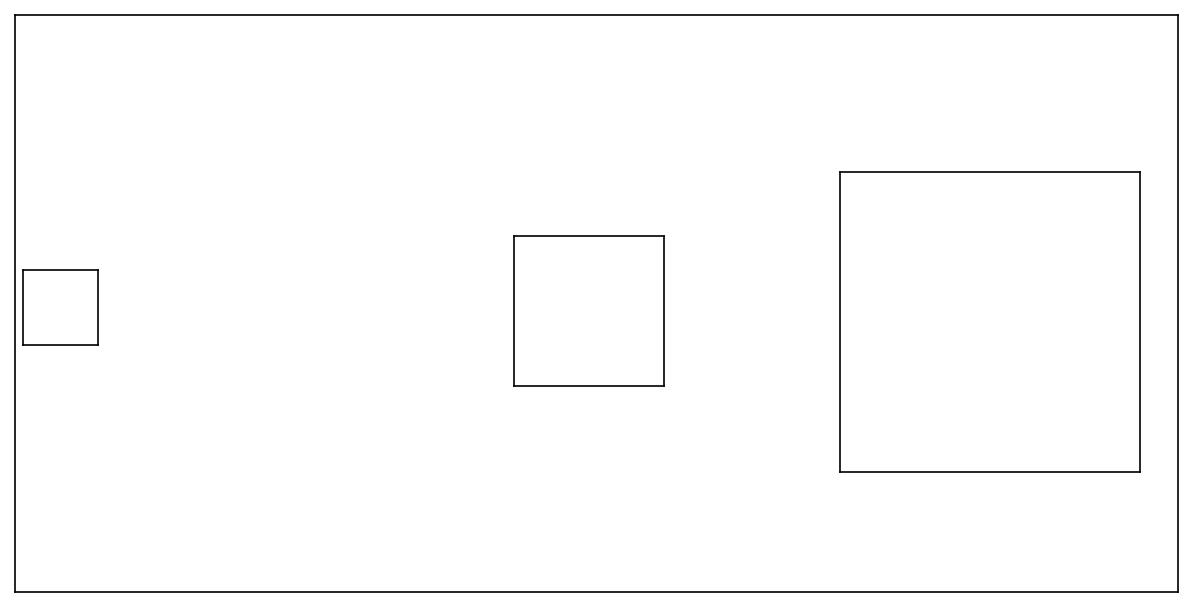

In [19]:
# For reference, this is 5 inches x 10 inches
fig, ax = new_map(1,1, figsize=(10,5))
# Visualizing three different sizes at various positions
for s,l in zip(["xs","sm","md"], ["center left", "center", "center right"]):
    # Calling the function to update the defaults
    InsetMap.set_size(size=s)
    inset_map(ax=ax, location=l, xticks=[], yticks=[])

# Resetting the sizes
InsetMap.set_size(size="sm")

## **Creating Inset Map Indicators**
A common complementary element to an inset map is an *indicator*, an additional element that places the inset map in context relevant to the parent axes in which the inset axes resides.

While [Wikipedia](https://en.wikipedia.org/wiki/Map_layout#Inset_map) lists 4 types of inset maps, only two require indicators: `Locators` (or `Extent` indicators) and `Detail`.

*Note: The following sections are somewhat abbreviated, skipping the class/function division between elements in the name of brevity. I would recommend reading the Inset Map tutorial at the top of this page if you haven't already to understand more, as it functions practically the same as each of the following indicators.*

### **Extent Indicators**
Extent indicators can be used to show the extent of one axis on another. This is most often used with an inset map that is a "zoomed-out" version of the parent axis, with the indicator showing the bounds of the parent axis on the smaller inset map, as shown below.

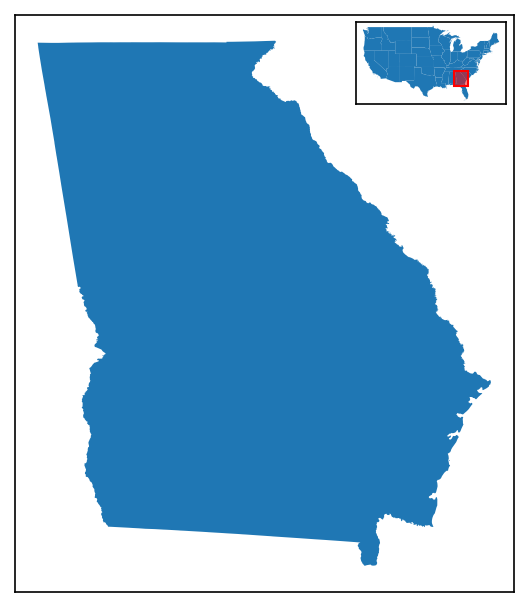

In [20]:
# Defining the inset map
im = InsetMap("upper right", size=1, pad=0.05, xticks=[], yticks=[], to_plot=[{"data":contiguous}])

# Creating a plot of Georgia
fig, ax = new_map(1,1, figsize=(5,5))
states.query(f"NAME=='Georgia'").plot(ax=ax)

# Plotting the inset map
iax = im.create(ax)

# Creating the extent indicator, which appears by-default as a red square on the map
indicate_extent(iax, ax, 3857, 3857)

Extent indicators can be created either through the `indicate_extent()` function, as shown above, or via an `ExtentIndicator` object (note the name difference!), used with a `.create()` call (just like how `InsetMap` works). The following options are permitted:

- `pax`: the axis upon which to *plot* the extent indicator. Must be a valid `matplotlib.axes.Axes` object.

- `bax`: the axis from which the *bounds* of the extent indicator are determined. Must be a valid `matplotlib.axes.Axes` object.

- `pcrs`: the CRS of the axis that is being used for plotting (`pax`). Will accept any `pyproj` CRS value (including strings and integers).

- `bcrs`: the CRS of the axis that is being used for determining the extent/bounds (`bax`). Will accept any `pyproj` CRS value (including strings and integers).

  - *Note: the 4 above options are not included when creating an `ExtentIndicator` object, but are instead arguments to add to the `.create()` call (i.e. `.create(pax, bax, pcrs, bcrs)`).*

- `to_return`: an optional argument to return something after the creation of the indicator for further manipulation. Can be any of `shape` (to return the `shapely.Polygon` object), `patch` (to return the `matplotlib.patches.Polygon`), `fig` (to return the coordinates of the indicator shape in `fig.transFigure` coordinates), or `ax` (to return the coordinates of the indicator shape in `ax.transAxes` coordinates). Default is `None`, returning nothing.

- `straighten`: whether or not to force-align the extent indicator to point up-and-down by calling `shapely.envelope` on the bounds. This is useful for "skewed" plots, where a drastically different projection is being used for each relevant axis. Can be either `True` (default) or `False`.

- `pad`: how much to "pad" or "buffer" the extent indicator by, adding additional area, which can oftentimes be helpful in busy maps. Accepts any integer or float greater than zero (you can only add area, not take away). Default is 5% (0.05).

- `plot`: whether or not to plot the indicator. Can be either `True` (default) or `False`.

- `facecolor`: the facecolor of the indicator box. Will accept any matplotlib color value. Default is `red`.

- `linecolor`: the linecolor of the indicator box (i.e. of the edge). Will accept any matplotlib color value. Default is `red`.

- `alpha`: the transparency of the *facecolor* of the indicator box. This does not impact the `linecolor` transparency! Default is 0.5.

- `linewidth`: The width of the edges of the box. Will accept any positive integer. Default is 1.

- `kwargs`: Any additional keyword arguments valid for [`matplotlib.patches.Polygon`](https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Polygon.html) may also be passed.


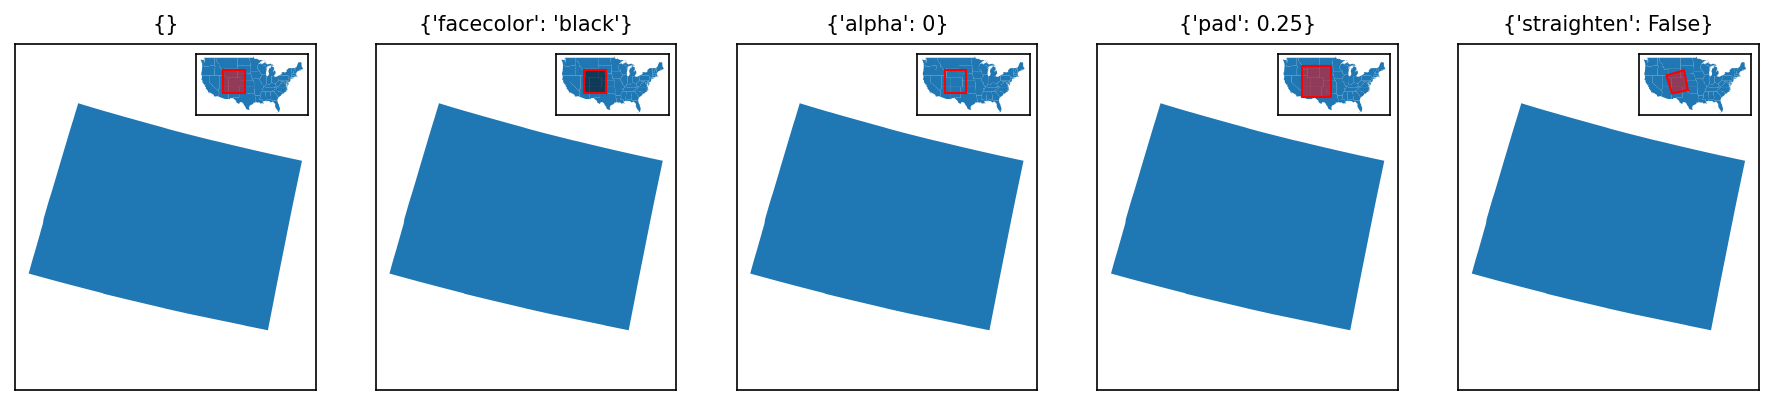

In [21]:
# Setting up an inset map
im = InsetMap(location="upper right", size=0.75, pad=0.05, xticks=[], yticks=[], to_plot=[{"data":contiguous}])
# What will be changed for each extent indicator
modifications = [
    {}, # default for comparison
    {"facecolor":"black"},
    {"alpha":0}, # making the facecolor invisible
    {"pad":0.25}, # extra padding
    {"straighten":False}, # turning straighten off
]
fig, axs = new_map(1,5, figsize=(15,3))
for ax,m in zip(axs.flatten(), modifications):
    # Note that here I am intentionally plotting Colorado with an incorrect CRS, to show the effects of straighten
    states.query(f"NAME=='Colorado'").to_crs(2240).plot(ax=ax)
    ax.set_aspect(1, adjustable="datalim") # this is just making things square-ish for us
    ax.set_title(m, fontsize=10)
    iax = im.create(ax) # creating the inset map
    indicate_extent(iax, ax, 3857, 2240, **m)

### **Detail Indicators**
In all of the examples above, the extent indicator was plotted on the inset map. This does not *have* to be the case: the function will work just as well in the opposite manner.

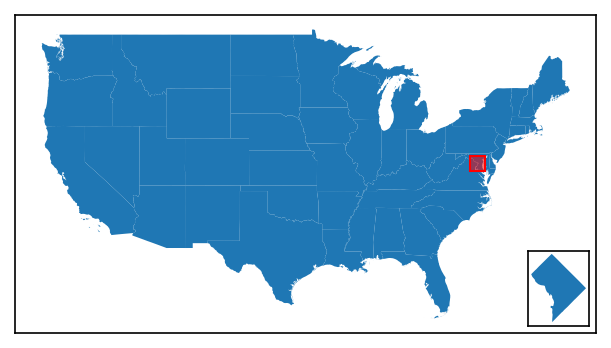

In [22]:
# Defining the inset map, which will be of Washington, DC (!)
im = InsetMap("lower right", size=0.5, pad=0.05, xticks=[], yticks=[], to_plot=[{"data":washington_dc}])

# Creating a plot of the contiguous US
fig, ax = new_map(1,1, figsize=(5,5))
contiguous.plot(ax=ax)

# Plotting the inset map
iax = im.create(ax)

# Creating the extent indicator, which appears by-default as a red square on the map
# note we've added some padding to make it more visible
indicate_extent(ax, iax, 3857, 3857, pad=3)

However, usually in such circumstances you want to *connect the extent indicator to the inset map*, to make it clear what it is showing. This is what distinguishes a *detail* indicator from an *extent* indicator.

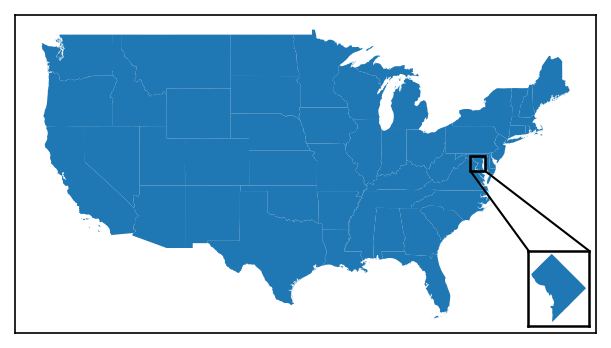

In [23]:
# The code below is the same, except for the very last function
im = InsetMap("lower right", size=0.5, pad=0.05, xticks=[], yticks=[], to_plot=[{"data":washington_dc}])

fig, ax = new_map(1,1, figsize=(5,5))
contiguous.plot(ax=ax)

iax = im.create(ax)

# Creating the detail indicator, which appears slightly differently to an extent indicator
indicate_detail(ax, iax, 3857, 3857, pad=3)

Detail indicators can be created either through the `indicate_detail()` function, as shown above, or via a `DetailIndicator` object (note the name difference!), used with a `.create()` call (just like how `InsetMap` works). 

Both the function and class work by *creating an extent indicator first*, then connecting it to the inset axis. As such, the arguments are mostly the same, with a few key differences:

- `pax`: the *parent* axis, upon which to plot the extent indicator. Must be a valid `matplotlib.axes.Axes` object.

- `iax`: the *inset* axis from which the *bounds* of the extent indicator are determined, and to where the connections are drawn. Must be a valid `matplotlib.axes.Axes` object.

- `pcrs`: the CRS of the *parent* axis (`pax`). Will accept any `pyproj` CRS value (including strings and integers).

- `icrs`: the CRS of the *inset* axis (`iax`). Will accept any `pyproj` CRS value (including strings and integers).

  - *Note: the 4 above options are not included when creating a `DetailIndicator` object, but are instead arguments to add to the `.create()` call (i.e. `.create(pax, iax, pcrs, icrs)`).*

- `to_return`: an optional argument to return something after the creation of the indicator for further manipulation. Can be any of `connectors` or `lines`, both of which will return the connection lines between the inset map and extent indicator. Default is `None`, returning nothing.

- `straighten`, `pad`, `plot`, `facecolor`, `alpha`, and `kwargs` all work the same as for an extent indicator.

The two different variables are:

- `linecolor`: the linecolor of the indicator box (i.e. of the edge), as well as the connection lines *and* the lines drawn around the inset map - this is because, in testing, I found that the design of the indicator was drastically improved by having it all match. Will accept any matplotlib color value. Default is `black` (not red!).

- `linewidth`: The width of the edges of the box, as well as the width of the edges of the lines drawn around the inset map. The connector lines will be 80% of this width, as determined by ad hoc testing. Will accept any positive integer. Default is 1.

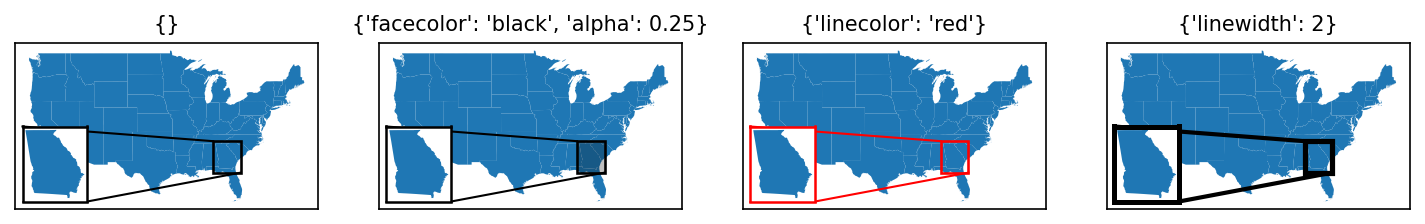

In [24]:
# Setting up an inset map
im = InsetMap("lower left", size=0.5, pad=0.05, xticks=[], yticks=[], to_plot=[{"data":states.query("NAME=='Georgia'")}])
# What will be changed for each extent indicator
modifications = [
    {}, # default for comparison
    {"facecolor":"black", "alpha":0.25},
    {"linecolor":"red"},
    {"linewidth":2},
]
fig, axs = new_map(1,4, figsize=(12,3))
for ax,m in zip(axs.flatten(), modifications):
    # Note that here I am intentionally plotting Colorado with an incorrect CRS, to show the effects of straighten
    contiguous.plot(ax=ax)
    ax.set_title(m, fontsize=10)
    iax = im.create(ax) # creating the inset map
    indicate_detail(ax, iax, 3857, 3857, **m)

The lines connecting the extent indicator to the inset map are determined based on the relative positions of the inset map and its indicator. As of `v3.0.0` (initial release), these are *not* user modifiable.